In [8]:
from rio_stac import create_stac_item
import rasterio
from odc.aws import s3_dump
import json
import pystac

In [42]:
base_s3 = "s3://deafrica-input-datasets/srtm_dem/"
dem = "srtm_africa.tif"

derivs = {
    "mrrtf": "srtm_africa_mrrtf.tif",
    "mrvbf": "srtm_africa_mrvbf.tif",
    "slope": "srtm_africa_slope.tif"
}

In [18]:
properties={
    "odc:product": "dem_srtm",
    "start_datetime": "1900-01-01T00:00:00",
    "end_datetime": "2100-01-01T00:00:00"
}

with rasterio.Env(AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com"):
    href = base_s3 + dem
    item = create_stac_item(
        href,
        id=dem,
        with_proj=True,
        properties=properties,
    )
    del item.assets["asset"]
    item.assets["elevation"] = pystac.Asset(
        href=href,
        title="elevation",
        media_type=pystac.MediaType.COG,
        roles=["data"],
    )
    item.set_self_href(base_s3 + "dem_srtm.stac-item.json")

    s3_dump(
        json.dumps(item.to_dict(), indent=2),
        item.self_href,
        ContentType="application/json",
        ACL="bucket-owner-full-control",
    )


In [43]:
properties={
    "odc:product": "dem_srtm_deriv",
    "start_datetime": "1900-01-01T00:00:00",
    "end_datetime": "2100-01-01T00:00:00"
}

with rasterio.Env(AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com"):
    href = base_s3 + derivs["slope"]
    item = create_stac_item(
        href,
        id="dem_srtm_derivs",
        with_proj=True,
        properties=properties,
    )
    del item.assets["asset"]
    for key, value in derivs.items():
        item.assets[key] = pystac.Asset(
            href=base_s3 + value,
            title=key,
            media_type=pystac.MediaType.COG,
            roles=["data"],
        )
    item.set_self_href(base_s3 + "dem_srtm_deriv.stac-item.json")

    s3_dump(
        json.dumps(item.to_dict(), indent=2),
        item.self_href,
        ContentType="application/json",
        ACL="bucket-owner-full-control",
    )


In [20]:
import datacube
dc = datacube.Datacube()

In [44]:
ds = dc.find_datasets(product="dem_srtm_deriv")
ds

[Dataset <id=556e77a2-a03b-5868-b9d9-9bcb65b9e9ab product=dem_srtm_deriv location=s3://deafrica-input-datasets/srtm_dem/dem_srtm_deriv.stac-item.json>]

In [46]:
with rasterio.Env(AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com"):
    data = dc.load(datasets=ds, resolution=(-10000, 10000))

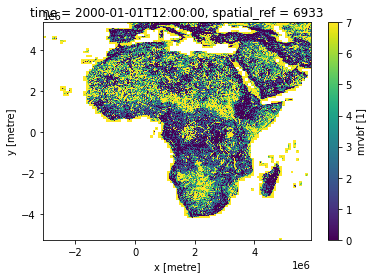

In [49]:
data["mrvbf"] = data.mrvbf.where(data.mrvbf != -32768)
data.mrvbf.plot(robust=True)

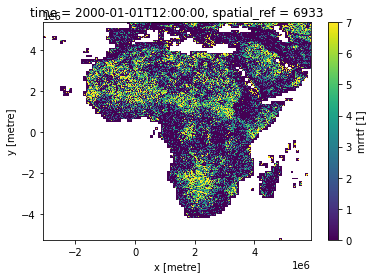

In [50]:
data["mrrtf"] = data.mrrtf.where(data.mrrtf != -32768)
data.mrrtf.plot(robust=True)

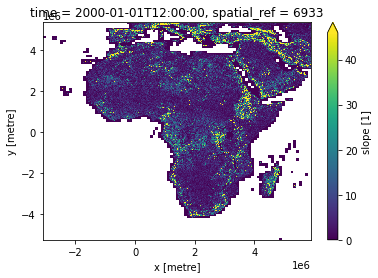

In [51]:
data["slope"] = data.slope.where(data.slope != -9999)
data.slope.plot(robust=True)